# Data Explanation and Preprocessing

### **1. EPS Forecast Dispersion (`ForecastDispersion`)**
**Source:** Diether, Malloy, and Scherbina (2002), *Journal of Finance*.

This signal measures the disagreement among sell-side analysts regarding a company's future earnings. The hypothesis is that high dispersion in analyst estimates represents high uncertainty or information asymmetry, which the market often misprices.

**Formula:**
$$\text{ForecastDispersion}_{i,t} = \frac{\text{stdev_est}_{i,t}}{|\text{mean_est}_{i,t}|}$$

**Construction Logic:**
* **Numerator:** The standard deviation of earnings estimates (`stdev_est`) for the current fiscal year.
* **Denominator:** The absolute value of the mean earnings estimate (`mean_est`).
* **Filters:** The sample is restricted to fiscal period indicator 1 (`fpi = 1`) and we ensure the forecast period end date is at least 30 days past the statistical period (`fpedats > statpers + 30`).
* **Predictability:** **Negative.** High dispersion implies lower future returns (Long-Short return: 0.79% monthly).

---

### **2. Payout Yield (`PayoutYield`)**
**Source:** Boudoukh et al. (2007), *Journal of Finance*.

Payout Yield improves upon the traditional Dividend Yield factor by recognizing that firms increasingly distribute cash to shareholders via share repurchases rather than cash dividends alone. It captures the total cash flow returned to equity holders.

**Formula:**
$$\text{PayoutYield}_{i,t} = \frac{\text{Dividends}_{t} + \text{Repurchases}_{t}}{\text{Market Equity}_{t-6}}$$

**Construction Logic:**
* **Numerator Components:**
  * *Dividends:* Sum of common and preferred dividends (`dvc`).
  * *Repurchases:* Purchase of common and preferred stock (`prstkc`) plus the reduction in preferred stock redemption value (`pstkrv`).
* **Denominator:** Market capitalization lagged by 6 months.
* **Exclusions:** Financial firms (SIC based), firms with negative book equity (`ceq <= 0`), or firms with less than 2 years of history in CRSP.
* **Predictability:** **Positive.** High payout yield implies higher future returns (Long-Short alpha: 0.28% monthly).

Source: https://openassetpricing.com/SignalDoc-Browser.html

In [ ]:
import pandas as pd
import numpy as np

path = "PredictorLSretWide.csv"
cols = ["ForecastDispersion", "PayoutYield"]

df = pd.read_csv(path, usecols=["date", *cols], parse_dates=["date"]).sort_values("date")

def summarize(x):
    x = x.dropna()
    n = x.size
    mu = x.mean()
    sd = x.std(ddof=1)
    t  = mu / (sd / np.sqrt(n))
    ann_mu = (mu/100) * 12
    ann_sd = (sd/100) * np.sqrt(12)
    sharpe = (mu / sd) * np.sqrt(12)
    return pd.Series({
        "n_months": n,
        "start": x.index[0],
        "end": x.index[-1],
        "mean_%_m": mu,
        "std_%_m": sd,
        "tstat": t,
        "ann_mean": ann_mu,
        "ann_vol": ann_sd,
        "sharpe": sharpe,
        "min_%": x.min(),
        "max_%": x.max(),
    })

out = df.set_index("date")[cols].apply(summarize)
print(out)


           ForecastDispersion          PayoutYield
n_months                  587                  858
start     1976-02-27 00:00:00  1953-07-31 00:00:00
end       2024-12-31 00:00:00  2024-12-31 00:00:00
mean_%_m             0.547001              0.26272
std_%_m              4.128106             3.034196
tstat                3.210382             2.536255
ann_mean              0.06564             0.031526
ann_vol              0.143002             0.105108
sharpe               0.459016             0.299944
min_%              -21.216207            -9.130231
max_%               14.140992            21.867256


In [ ]:
df_1976 = (df.loc[df["date"] >= "1976-12-31", ["date"] + cols]
             .sort_values("date")
             .reset_index(drop=True))

missing = df_1976[cols].isna().sum()
any_missing_rows = df_1976[cols].isna().any(axis=1).sum()

# check missing months
months = df_1976["date"].dt.to_period("M")
full = pd.period_range(months.min(), months.max(), freq="M")
missing_months = full.difference(months.unique())

print("rows:", len(df_1976))
print("missing per col: ", missing)
print("rows w/ any missing: ", any_missing_rows)
print("missing months:", len(missing_months))

rows: 577
missing per col:  ForecastDispersion    0
PayoutYield           0
dtype: int64
rows w/ any missing:  0
missing months: 0


train: 457 1976-12-31 00:00:00 -> 2014-12-31 00:00:00
test : 120 2015-01-30 00:00:00 -> 2024-12-31 00:00:00


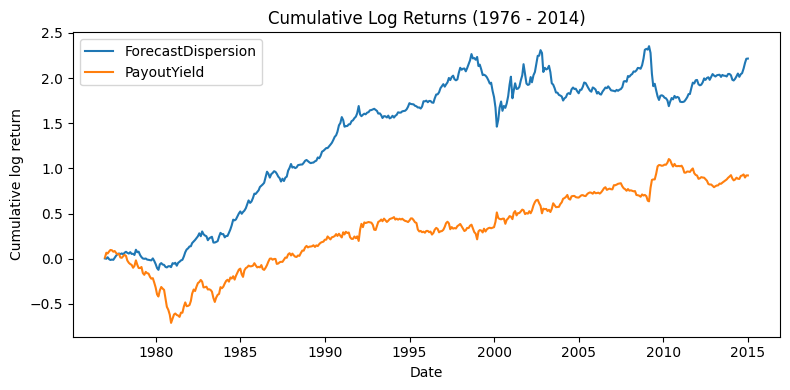

In [ ]:
import matplotlib.pyplot as plt

df = (pd.read_csv(path, parse_dates=["date"])
        .loc[lambda x: x["date"] >= "1976-12-31", ["date"] + cols]
        .sort_values("date")
        .reset_index(drop=True))

cutoff = pd.Timestamp("2014-12-31")

train_df = df[df["date"] <= cutoff].reset_index(drop=True)   # 1976-12 to 2014-12
test_df  = df[df["date"] >  cutoff].reset_index(drop=True)   # 2015-01 to 2024-12

print("train:", len(train_df), train_df["date"].min(), "->", train_df["date"].max())
print("test :", len(test_df),  test_df["date"].min(),  "->", test_df["date"].max())

logret = np.log1p(train_df[cols] / 100.0)
cum_logret = logret.cumsum()

plt.figure(figsize=(8, 4))
plt.plot(train_df["date"], cum_logret["ForecastDispersion"], label="ForecastDispersion")
plt.plot(train_df["date"], cum_logret["PayoutYield"], label="PayoutYield")
plt.title("Cumulative Log Returns (1976 - 2014)")
plt.xlabel("Date")
plt.ylabel("Cumulative log return")
plt.legend()
plt.tight_layout()
plt.show()


## **Hypothesis: Signal Seasonality around Fiscal Year Ends and Quarterly Reporting Peaks**

We hypothesize that the efficacy of `ForecastDispersion` and `PayoutYield` varies systematically around (1) **common Fiscal Year End (FYE) months** and (2) **quarterly reporting-season peaks**. In other words, these signals may behave differently when earnings-related information flow is unusually concentrated.

We will test **two seasonality hypotheses**:

1. **FYE-month hypothesis:** performance differs in **December, January, June, and September**, which align with common FYE patterns and related reporting/board cycles.
2. **Quarterly reporting-peak hypothesis:** performance differs in months that typically capture the **earnings-season peak** for **Q1/Q2/Q3/Q4** reporting (e.g., **April Q1, July Q2 October Q3 Jan Q4**), reflecting the broader cadence of earnings releases for the typical fiscal calendar.

Below is the rationale for both hypotheses from a bottom-up (analyst behavior) and top-down (macro/flows) perspective.

### **1. Why Forecast Dispersion Should Decay in FYE / Reporting-Peak Months**

We expect `ForecastDispersion` to act as a compressed or lower-fidelity signal during these periods, resulting in lower long-short returns.

* **Convergence of Estimates:** As firms approach earnings announcements, analysts update models with recent guidance and macro inputs, causing the standard deviation of estimates (`stdev_est`) to shrink. When dispersion compresses broadly, the spread between high- and low-dispersion portfolios narrows, reducing effective exposure.
* **Resolution of Uncertainty:** `ForecastDispersion` earns a premium because it proxies for information uncertainty. During earnings-heavy months, uncertainty is resolved by the release itself; the market rapidly reprices on realized information, weakening the premium linked to uncertainty.
* **Idiosyncratic Dominance:** In non-peak months, macro news can create heterogeneous analyst reactions and persistent dispersion. During reporting peaks, company-specific disclosures dominate and many analysts update off the same press release, reducing “differences of opinion” that drive the signal.

### **2. Why Payout Yield Should Improve in FYE / Reporting-Peak Months**

We expect `PayoutYield` to become a higher-fidelity signal during these periods, resulting in higher long-short returns.

* **Concrete Data vs. Estimates:** Payout Yield is grounded in realized payouts and accounting data rather than opinions. Around earnings releases, firms often announce dividend increases or new/expanded buyback authorizations, making the signal more current and salient.
* **Flight to Quality / Value Tilt in Volatile Windows:** Earnings seasons often coincide with elevated volatility and heightened scrutiny. Investors may rotate toward tangible cash-flow and shareholder-return characteristics, benefiting high payout firms relative to low payout firms.
* **Capital Allocation Timing:** Corporate payout decisions and buyback execution tend to align with the fiscal calendar and blackout windows. After blackout periods end (often immediately following reporting), actual corporate bid/repurchase activity can increase, creating direct buying pressure that may disproportionately support high payout firms.

### **Testing Plan (High Level)**

We will evaluate whether long-short returns differ (and in which direction) when conditioning on:

* **FYE months:** Dec/Jan/Jun/Sep vs all other months
* **Quarterly peak months:** months corresponding to Q1/Q2/Q3/Q4 reporting peaks vs non-peak months (and/or each peak month individually vs the rest)

The key question: **Does `ForecastDispersion` underperform while `PayoutYield` outperforms during these earnings-heavy windows, consistent with the mechanisms above?**


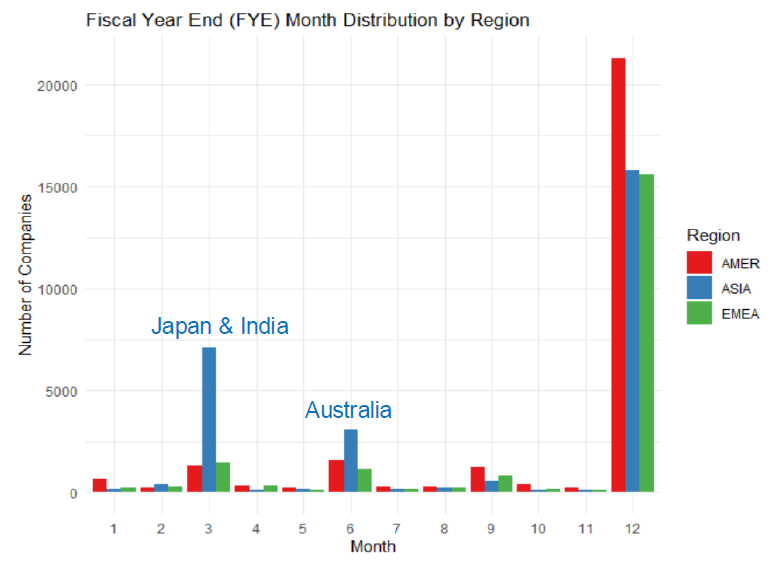

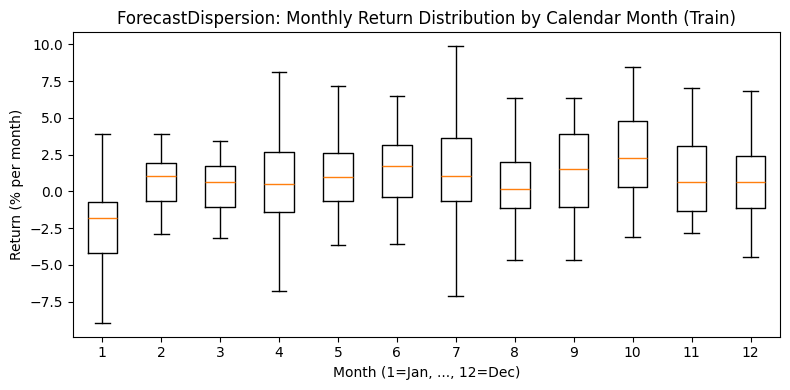

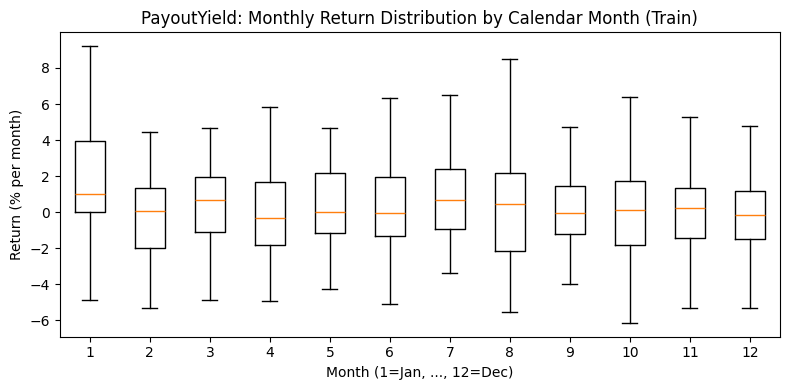

,signal,special_months,n_special,mean_special_%,std_special_%,n_rest,mean_rest_%,std_rest_%,diff_(special-rest)_%,Welch_t,p_value_t,p_value_MW,p_value_KS
0,ForecastDispersion,"[1, 4, 7]",114,-0.412506,4.689805,343,0.898347,3.802505,-1.310853,-2.703584,0.007577,0.001369,0.001222
1,PayoutYield,"[1, 4, 7]",114,0.660001,3.323018,343,0.111175,2.957709,0.548826,1.568920,0.118460,0.115744,0.149326


In [ ]:
from scipy import stats
from math import sqrt

train_df["month"] = train_df["date"].dt.month

special_months = {1, 4, 7}
train_df["is_special"] = train_df["month"].isin(special_months)

for c in cols:
    data_by_month = [train_df.loc[train_df["month"] == m, c].dropna().values for m in range(1, 13)]
    plt.figure(figsize=(8, 4))
    plt.boxplot(data_by_month, tick_labels=list(range(1, 13)), showfliers=False)
    plt.title(f"{c}: Monthly Return Distribution by Calendar Month (Train)")
    plt.xlabel("Month (1=Jan, ..., 12=Dec)")
    plt.ylabel("Return (% per month)")
    plt.tight_layout()
    plt.show()

# Hypothesis tests: special months vs rest
def welch_ttest(a, b):
    a = np.asarray(a); b = np.asarray(b)
    na, nb = a.size, b.size
    ma, mb = a.mean(), b.mean()
    va, vb = a.var(ddof=1), b.var(ddof=1)
    t = (ma - mb) / np.sqrt(va/na + vb/nb)
    # Welch-Satterthwaite df
    df_ = (va/na + vb/nb)**2 / ((va/na)**2/(na-1) + (vb/nb)**2/(nb-1))
    return t, df_

rows = []
for c in cols:
    a = train_df.loc[train_df["is_special"], c].dropna()
    b = train_df.loc[~train_df["is_special"], c].dropna()

    # group stats
    stats_a = (a.size, a.mean(), a.std(ddof=1))
    stats_b = (b.size, b.mean(), b.std(ddof=1))
    diff = stats_a[1] - stats_b[1]  # special - rest

    t_res = stats.ttest_ind(a, b, equal_var=False, nan_policy="omit")
    t_stat = float(t_res.statistic)
    p_t = float(t_res.pvalue)

    # Nonparametric
    u_res = stats.mannwhitneyu(a, b, alternative="two-sided")
    p_mw = float(u_res.pvalue)

    ks_res = stats.ks_2samp(a, b, alternative="two-sided", mode="auto")
    p_ks = float(ks_res.pvalue)

    rows.append({
        "signal": c,
        "special_months": str(list(special_months)),
        "n_special": stats_a[0],
        "mean_special_%": stats_a[1],
        "std_special_%": stats_a[2],
        "n_rest": stats_b[0],
        "mean_rest_%": stats_b[1],
        "std_rest_%": stats_b[2],
        "diff_(special-rest)_%": diff,
        "Welch_t": t_stat,
        "p_value_t": p_t,
        "p_value_MW": p_mw,
        "p_value_KS": p_ks,
    })

test_table = pd.DataFrame(rows)
display(test_table)

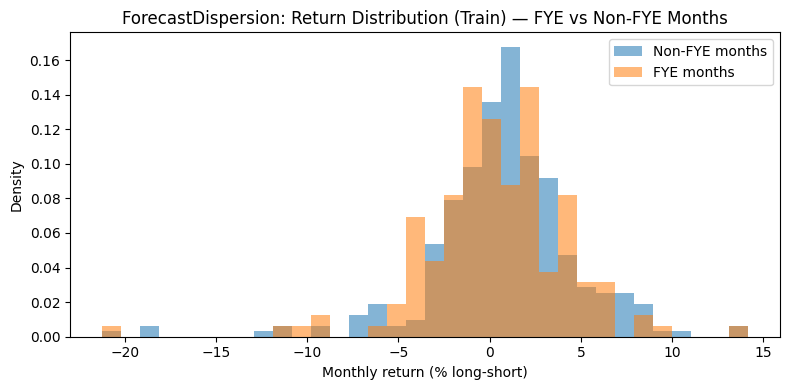

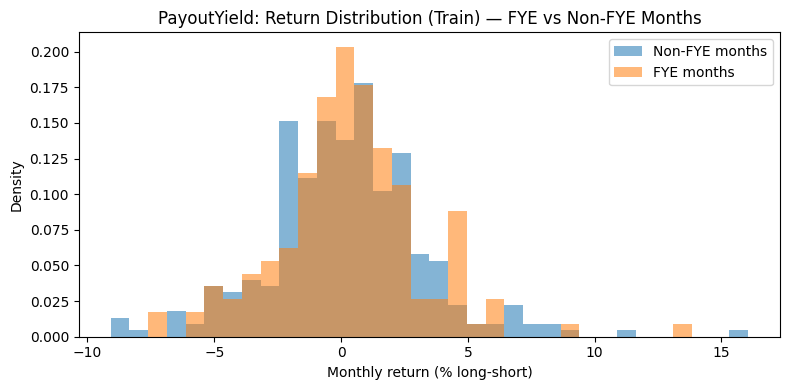

In [ ]:
mask_fye = train_df["month"].isin({1, 6, 9, 12})

for sig in cols:
    x_fye = train_df.loc[mask_fye, sig].dropna().values
    x_non = train_df.loc[~mask_fye, sig].dropna().values

    xmin = min(x_fye.min(), x_non.min())
    xmax = max(x_fye.max(), x_non.max())
    bins = np.linspace(xmin, xmax, 35)

    plt.figure(figsize=(8, 4))
    plt.hist(x_non, bins=bins, density=True, alpha=0.55, label="Non-FYE months")
    plt.hist(x_fye, bins=bins, density=True, alpha=0.55, label="FYE months")
    plt.title(f"{sig}: Return Distribution (Train) — FYE vs Non-FYE Months")
    plt.xlabel("Monthly return (% long-short)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
cols = ["ForecastDispersion", "PayoutYield"]
month_to_test = 1

# January vs Rest
def jan_vs_rest(train_df, col, alt):
    jan  = train_df.loc[train_df["month"] == month_to_test, col].dropna().to_numpy()
    rest = train_df.loc[train_df["month"] != month_to_test, col].dropna().to_numpy()

    na, nb = len(jan), len(rest)
    ma, mb = jan.mean(), rest.mean()
    va, vb = jan.var(ddof=1), rest.var(ddof=1)

    # Welch t + df
    t_stat = (ma - mb) / np.sqrt(va/na + vb/nb)
    df_welch = (va/na + vb/nb)**2 / ((va/na)**2/(na-1) + (vb/nb)**2/(nb-1))

    # one-sided p-value (Welch t)
    if alt == "less":      # Jan < Rest
        p_one = stats.t.cdf(t_stat, df_welch)
    elif alt == "greater": # Jan > Rest
        p_one = stats.t.sf(t_stat, df_welch)
    else:
        raise ValueError("alt must be 'less' or 'greater'")

    # one-sided Mann–Whitney U (nonparametric)
    p_mw_one = stats.mannwhitneyu(jan, rest, alternative=alt).pvalue

    return {
        "signal": col,
        "alt": f"Jan {('<' if alt=='less' else '>')} Rest",
        "n_jan": na,
        "mean_jan_%": ma,
        "n_rest": nb,
        "mean_rest_%": mb,
        "diff_(jan-rest)_%": ma - mb,
        "welch_t": t_stat,
        "welch_df": df_welch,
        "p_one_sided_welch": p_one,
        "p_one_sided_MW": p_mw_one,
    }

out = pd.DataFrame([
    jan_vs_rest(train_df, "ForecastDispersion", alt="less"),    # expect worse in Jan
    jan_vs_rest(train_df, "PayoutYield",        alt="greater"), # expect better in Jan
])

display(out)



,signal,alt,n_jan,mean_jan_%,n_rest,mean_rest_%,diff_(jan-rest)_%,welch_t,welch_df,p_one_sided_welch,p_one_sided_MW
0,ForecastDispersion,Jan < Rest,38,-2.775237,419,0.874860,-3.650097,-5.025115,42.713055,0.000005,3.742653e-09
1,PayoutYield,Jan > Rest,38,1.389012,419,0.144608,1.244405,1.831449,40.511503,0.037197,1.141316e-02


We see that in the special months, the returns for forecast dispersion is overall lower than the returns from the rest of the months. On the contrary, the return for payout yield signal in the special fye months are higher than the rest of the months. However, we see that this difference is generally not statistically siginificant besides in the KS test to see if the data come from a different distribution, thus we fail to reject the null hypothesis. One important discovery is that for both the signal, Jan's performance is significantly different for both signals aligning with our hypothesis.

# Portfolio Construction
From the above hypothesis test and results in training, we decided to only include January and April as the special FYE month. The switch strategy uses PayoutYield signal to construct the portfolio in January and April and ForecastDispersion otherwise.

'Train stats (1976-12 to 2014-12)'

,start,end,n_months,CAGR,AnnVol,Sharpe,MaxDD,TotalReturn
strategy,,,,,,,,
FD only,1976-12-31,2014-12-31,457,5.989018,14.121067,0.485531,-55.211160,816.258766
PY only,1976-12-31,2014-12-31,457,2.449582,10.594686,0.280988,-55.380440,151.340829
50/50 always,1976-12-31,2014-12-31,457,4.632080,8.717041,0.564021,-36.319548,460.923067
Special: PY only; Non-special: 50/50,1976-12-31,2014-12-31,457,6.784190,9.229824,0.758777,-37.152533,1117.979685
Special: 70/30 PY/FD; Non-special: 50/50,1976-12-31,2014-12-31,457,5.517258,8.601607,0.668632,-36.631470,673.101618
Switch strategy,1976-12-31,2014-12-31,457,10.673318,12.948650,0.851810,-37.614853,4656.654826


'Test stats (2015-01 to 2024-12)'

,start,end,n_months,CAGR,AnnVol,Sharpe,MaxDD,TotalReturn
strategy,,,,,,,,
FD only,2015-01-30,2024-12-31,120,5.562787,15.362903,0.430939,-43.472599,71.833759
PY only,2015-01-30,2024-12-31,120,1.363762,12.191280,0.168645,-41.243625,14.505730
50/50 always,2015-01-30,2024-12-31,120,3.990354,9.202466,0.471421,-19.353449,47.887199
Special: PY only; Non-special: 50/50,2015-01-30,2024-12-31,120,6.225666,10.602639,0.620561,-14.370113,82.934090
Special: 70/30 PY/FD; Non-special: 50/50,2015-01-30,2024-12-31,120,4.921813,9.308421,0.562370,-17.293991,61.680580
Switch strategy,2015-01-30,2024-12-31,120,10.564588,14.559563,0.762604,-26.173718,172.998671


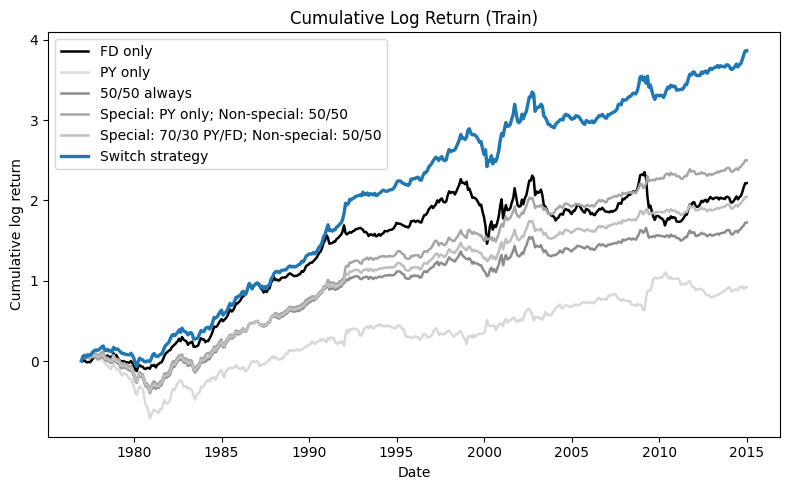

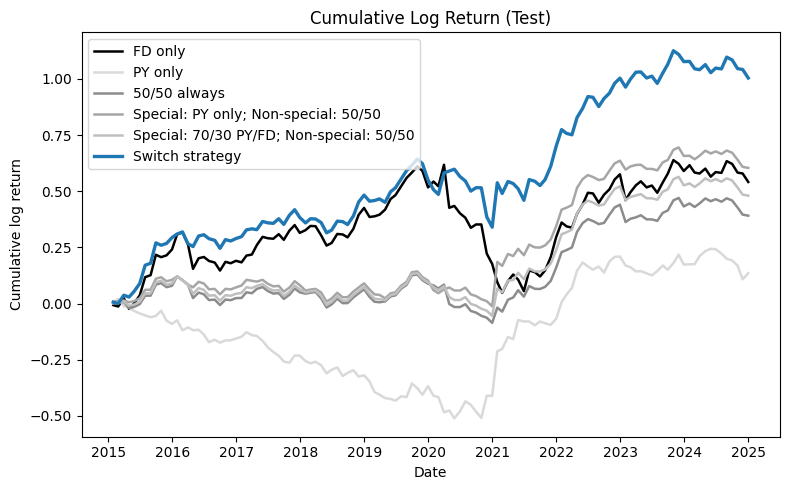

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = "PredictorLSretWide.csv"
sig_fd = "ForecastDispersion"
sig_py = "PayoutYield"
cols = [sig_fd, sig_py]

# Load and filter to 1976-12-31 onward
df = (pd.read_csv(path, parse_dates=["date"])
        .loc[lambda x: x["date"] >= "1976-12-31", ["date"] + cols]
        .sort_values("date")
        .reset_index(drop=True))

# Define train/test split
cutoff = pd.Timestamp("2014-12-31")
train = df[df["date"] <= cutoff].copy()
test  = df[df["date"] >  cutoff].copy()

# CHANGE THIS FOR MONTHS
special_months = [1, 4]


for d in (df, train, test):
    d["month"] = d["date"].dt.month
    d["is_special"] = d["month"].isin(special_months)  # Jan only proxy

def make_strategy_returns(d: pd.DataFrame, name: str) -> pd.Series:
    is_sp = d["is_special"].to_numpy()
    fd = d[sig_fd].to_numpy()
    py = d[sig_py].to_numpy()

    if name == "FD only":
        w_py = np.zeros(len(d))
        w_fd = 1.0 - w_py
    elif name == "PY only":
        w_py = np.ones(len(d))
        w_fd = 1.0 - w_py
    elif name == "50/50 always":
        w_py = np.full(len(d), 0.5)
        w_fd = 1.0 - w_py
    elif name == "Special: PY only; Non-special: 50/50":
        w_py = np.where(is_sp, 1.0, 0.5)
        w_fd = 1.0 - w_py
    elif name == "Special: 70/30 PY/FD; Non-special: 50/50":
        w_py = np.where(is_sp, 0.7, 0.5)
        w_fd = 1.0 - w_py
    elif name == "Switch strategy":  # renamed
        w_py = np.where(is_sp, 1.0, 0.0)
        w_fd = 1.0 - w_py
    else:
        raise ValueError(f"Unknown strategy: {name}")

    r_pct = w_fd * fd + w_py * py
    return pd.Series(r_pct, index=d["date"], name=name)

strategies = [
    "FD only",
    "PY only",
    "50/50 always",
    "Special: PY only; Non-special: 50/50",
    "Special: 70/30 PY/FD; Non-special: 50/50",
    "Switch strategy",
]

# Build return panels (percent per month)
ret_full  = pd.concat([make_strategy_returns(df, s)    for s in strategies], axis=1)
ret_train = pd.concat([make_strategy_returns(train, s) for s in strategies], axis=1)
ret_test  = pd.concat([make_strategy_returns(test, s)  for s in strategies], axis=1)

def perf_stats(r_pct: pd.Series) -> dict:
    r = r_pct.dropna() / 100.0
    n = len(r)
    if n == 0:
        return {}
    equity = (1.0 + r).cumprod()
    total_return = equity.iloc[-1] - 1.0
    cagr = equity.iloc[-1] ** (12.0 / n) - 1.0

    mu_m = r.mean()
    sd_m = r.std(ddof=1)
    ann_vol = sd_m * np.sqrt(12.0)
    ann_sharpe = (mu_m / sd_m) * np.sqrt(12.0) if sd_m > 0 else np.nan

    peak = equity.cummax()
    dd = equity / peak - 1.0
    maxdd = dd.min()

    return {
        "start": r.index.min().date(),
        "end": r.index.max().date(),
        "n_months": n,
        "CAGR": cagr,
        "AnnVol": ann_vol,
        "Sharpe": ann_sharpe,
        "MaxDD": maxdd,
        "TotalReturn": total_return,
    }

def stats_table(panel: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for c in panel.columns:
        rows.append({"strategy": c, **perf_stats(panel[c])})
    return pd.DataFrame(rows).set_index("strategy")

def format_table(t: pd.DataFrame) -> pd.DataFrame:
    out = t.copy()
    for col in ["CAGR", "AnnVol", "MaxDD", "TotalReturn"]:
        out[col] = out[col].astype(float) * 100.0
    return out

stats_train = stats_table(ret_train)
stats_test  = stats_table(ret_test)

display("Train stats (1976-12 to 2014-12)", format_table(stats_train))
display("Test stats (2015-01 to 2024-12)", format_table(stats_test))

color_map = {
    "FD only": "#000000",
    "PY only": "#D9D9D9",
    "50/50 always": "#8C8C8C",
    "Special: PY only; Non-special: 50/50": "#A6A6A6",
    "Special: 70/30 PY/FD; Non-special: 50/50": "#BFBFBF",
    "Switch strategy": "tab:blue",
}

def plot_cum_log(panel: pd.DataFrame, title: str):
    r = panel / 100.0
    equity = (1.0 + r).cumprod()
    cum_log = np.log(equity)

    plt.figure(figsize=(8, 5))
    for c in cum_log.columns:
        lw = 2.4 if c == "Switch strategy" else 1.8
        plt.plot(cum_log.index, cum_log[c], label=c, color=color_map.get(c, None), linewidth=lw)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative log return")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Separate plots for training and testing
plot_cum_log(ret_train, "Cumulative Log Return (Train)")
plot_cum_log(ret_test,  "Cumulative Log Return (Test)")


Using **January + April** as special months improves the combined strategy’s risk-adjusted performance relative to the standalone signals and the constant 50/50 mix. In-sample (1976–2014), the **Switch strategy** (PayoutYield in special months, ForecastDispersion otherwise) delivers the strongest profile (CAGR ≈ **10.7%**, Sharpe ≈ **0.85**) versus **FD only** (≈ 6.0%, 0.49) and **PY only** (≈ 2.45%, 0.28), suggesting the month-based regime meaningfully tilts exposure toward the signal that historically works best in those months. Out-of-sample (2015–2024), the same pattern persists: the **Switch strategy** remains the top performer (CAGR ≈ **10.6%**, Sharpe ≈ **0.76**) and beats both **50/50 always** (≈ 4.0%, 0.47) and the individual legs, indicating the month rule is not purely in-sample overfit. The trade-off is that the Switch strategy takes on higher volatility and still experiences sizable drawdowns, but its consistently better performance on these special months adds economically meaningful value.
